## Fine tune stable diffusion model for image to image generation by Shoaib Hoque

### Generate Paired Data for Denoising

In [ ]:
import os
import numpy as np
from PIL import Image
import random

def add_noise(image, noise_level=25):
    """
    Adds Gaussian noise to an image.
    Args:
        image (PIL.Image): Input image.
        noise_level (int): Standard deviation of the Gaussian noise.
    Returns:
        PIL.Image: Noisy image.
    """
    np_image = np.array(image).astype(np.float16)
    noise = np.random.normal(0, noise_level, np_image.shape)
    noisy_image = np_image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

# Directories for saving
os.makedirs('./paired_data/input', exist_ok=True)
os.makedirs('./paired_data/target', exist_ok=True)

# Generate paired data
data_dir = './clean_images'  # Replace with the directory of your clean images
for i, file_name in enumerate(os.listdir(data_dir)):
    image_path = os.path.join(data_dir, file_name)
    image = Image.open(image_path).convert("RGB")

    noisy_image = add_noise(image, noise_level=random.randint(15, 50))  # Add random noise level

    noisy_image.save(f'./paired_data/input/noisy_{i}.jpg')
    image.save(f'./paired_data/target/clean_{i}.jpg')

print("Paired noisy-clean dataset created!")


Paired noisy-clean dataset created!


### Upload Dataset

In [1]:
import zipfile
import os

# Path to zip file
zip_path = "/content/paired_data.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./paired_data')

# Verify dataset structure
print("Dataset structure:")
for root, dirs, files in os.walk('./paired_data'):
    print(root, len(files), "files")


Dataset structure:
./paired_data 0 files
./paired_data/paired_data 0 files
./paired_data/paired_data/input 6 files
./paired_data/paired_data/target 6 files


### Prepare Dataset

In [2]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None, augmentations=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.target_files = sorted(os.listdir(target_dir))
        self.transform = transform
        self.augmentations = augmentations

        # Ensure input and target files align
        assert len(self.input_files) == len(self.target_files), "Mismatch between input and target files"

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        target_path = os.path.join(self.target_dir, self.target_files[idx])

        # Open images and ensure RGB mode
        input_image = Image.open(input_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")

        # Apply optional augmentations
        if self.augmentations:
            input_image = self.augmentations(input_image)
            target_image = self.augmentations(target_image)

        # Apply transformations
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image


# Define preprocessing and augmentations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])

# Create dataset and dataloader
input_dir = './paired_data/paired_data/input'
target_dir = './paired_data/paired_data/target'
dataset = PairedImageDataset(input_dir, target_dir, transform=transform, augmentations=augmentations)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Adjust batch size if needed

# Test the dataloader
for input_images, target_images in dataloader:
    print("Input batch shape:", input_images.shape)
    print("Target batch shape:", target_images.shape)
    break


Input batch shape: torch.Size([1, 3, 512, 512])
Target batch shape: torch.Size([1, 3, 512, 512])


### Get Stable diffusion Model

In [3]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

# Load pre-trained Stable Diffusion model
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16
).to("cuda")

print("Stable Diffusion model loaded successfully!")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion model loaded successfully!


### Fine Tune the Model

In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import StableDiffusionPipeline

# Initialize tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

def fine_tune_model(dataloader, pipeline, epochs=2, accumulation_steps=2):
    pipeline.unet.train()
    optimizer = optim.AdamW(pipeline.unet.parameters(), lr=5e-6)

    for epoch in range(epochs):
        total_loss = 0
        for step, (input_images, target_images) in enumerate(dataloader):
            # Normalize and move to device
            input_images = input_images.to("cuda", dtype=torch.float16) * 2 - 1
            target_images = target_images.to("cuda", dtype=torch.float16) * 2 - 1

            # Encode and clamp latents
            latents_input = torch.clamp(pipeline.vae.encode(input_images).latent_dist.sample() * 0.18215, -1.0, 1.0)
            latents_target = torch.clamp(pipeline.vae.encode(target_images).latent_dist.sample() * 0.18215, -1.0, 1.0)

            # Generate text embeddings
            text_inputs = tokenizer(["a portrait of a young man"] * len(input_images),
                                     padding="max_length",
                                     max_length=77,
                                     truncation=True,
                                     return_tensors="pt").to("cuda")
            encoder_hidden_states = text_encoder(text_inputs.input_ids)[0]

            # Add noise to latents
            noise = torch.randn_like(latents_input)
            timesteps = torch.randint(0, 1000, (latents_input.size(0),), device=latents_input.device).long()
            noisy_latents = pipeline.scheduler.add_noise(latents_input, noise, timesteps)

            # Predict noise and calculate loss
            with autocast(device_type="cuda"):
                noise_pred = pipeline.unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise) / accumulation_steps

            # Backpropagation
            loss.backward()
            total_loss += loss.item()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
                # Clip gradients and update weights
                torch.nn.utils.clip_grad_norm_(pipeline.unet.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
        # Save fine-tuned pipeline
        pipeline.unet.save_pretrained(f"./fine_tuned_unet_epoch_{epoch + 1}")
        pipeline.save_pretrained(f"./fine_tuned_pipeline_epoch_{epoch + 1}")  # Optional

# Fine-tune the model
fine_tune_model(dataloader, pipeline, epochs=12, accumulation_steps=2)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Epoch 1/12, Loss: nan
Epoch 2/12, Loss: nan
Epoch 3/12, Loss: nan
Epoch 4/12, Loss: nan
Epoch 5/12, Loss: nan
Epoch 6/12, Loss: nan
Epoch 7/12, Loss: nan
Epoch 8/12, Loss: nan
Epoch 9/12, Loss: nan
Epoch 10/12, Loss: nan
Epoch 11/12, Loss: nan
Epoch 12/12, Loss: nan


checking the GPU usage and clear extra cache if exist

In [5]:
!nvidia-smi

Thu Dec  5 13:57:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              31W /  70W |  14215MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import torch
torch.cuda.empty_cache()

### Test the Fine Tune Model

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

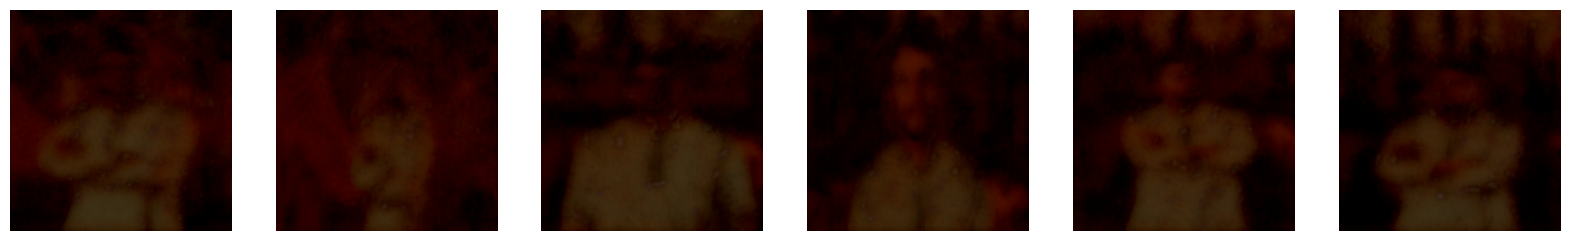

In [7]:
from PIL import Image
from torchvision.transforms.functional import to_tensor
from diffusers import StableDiffusionImg2ImgPipeline
import torch
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))  # Resize to 512x512
    image = to_tensor(image).permute(1, 2, 0).numpy()  # Convert to NumPy
    return image

# Clamp latents to avoid invalid values
def clamp_latents(latents):
    return torch.clamp(latents, -1.0, 1.0)

# Load pipeline
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda")

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("./fine_tuned_pipeline_epoch_12", torch_dtype=torch.float16).to("cuda")
# Disable NSFW detection
pipeline.safety_checker = None

# Test with preprocessed images
test_images = [
    preprocess_image("./paired_data/paired_data/input/noisy_0.jpg"),
    preprocess_image("./paired_data/paired_data/input/noisy_1.jpg"),
    preprocess_image("./paired_data/paired_data/input/noisy_2.jpg"),
    preprocess_image("./paired_data/paired_data/input/noisy_3.jpg"),
    preprocess_image("./paired_data/paired_data/input/noisy_4.jpg"),
    preprocess_image("./paired_data/paired_data/input/noisy_5.jpg"),
]

generated_images = []
for image in test_images:
    # Convert to PyTorch tensor and add batch dimension
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to("cuda", dtype=torch.float16)

    # Encode and clamp latents
    result_latents = pipeline.vae.encode(image_tensor).latent_dist.sample()
    result_latents = clamp_latents(result_latents)

    # Decode latents to image
    result_image = pipeline.vae.decode(result_latents).sample  # Extract tensor from DecoderOutput
    result_image = torch.clamp(result_image, 0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype("float32")
    generated_images.append(result_image)

# Display generated images
fig, axes = plt.subplots(1, len(generated_images), figsize=(20, 5))
for i, img in enumerate(generated_images):
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()
